## Data description

The data comprises 5,574 SMS messages. Each message is labelled as either 'ham' (legitimate) or spam.

Each line in `data.txt` corresponds to one message. The first word is the data label (either `ham` or `spam`), followed by a tab (`\t`) character and then the message.

In [0]:
with open('data/data.txt', 'r') as f:
    msgs = f.read().splitlines()

In [7]:
print(msgs[10])
print(msgs[11])

ham	I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today.
spam	SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info


In [8]:
# The default TensorFlow version on Colab is 1.x. Uncomment the below to use TensorFlow 2.x instead.
%tensorflow_version 1.x

TensorFlow is already loaded. Please restart the runtime to change versions.


In [9]:
import tensorflow as tf
tf.__version__

'2.2.0-rc1'

In [0]:
import pandas as pd
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import keras.optimizers

## **1. Some data cleaning and exploration**

In [11]:
df = pd.DataFrame(msgs)
df.head()

,0
0,"ham\tGo until jurong point, crazy.. Available ..."
1,ham\tOk lar... Joking wif u oni...
2,spam\tFree entry in 2 a wkly comp to win FA Cu...
3,ham\tU dun say so early hor... U c already the...
4,"ham\tNah I don't think he goes to usf, he live..."


In [0]:
df.columns = ['text']

In [13]:
df.head()

,text
0,"ham\tGo until jurong point, crazy.. Available ..."
1,ham\tOk lar... Joking wif u oni...
2,spam\tFree entry in 2 a wkly comp to win FA Cu...
3,ham\tU dun say so early hor... U c already the...
4,"ham\tNah I don't think he goes to usf, he live..."


In [0]:
df[['Class','text']] = df.text.str.split("\t",expand=True)

In [0]:
df.columns = ['Text', 'Class']

In [0]:
df['Class'] = df['Class'].replace(to_replace=['ham', 'spam'], value=[0, 1])

In [17]:
df.head()

,Text,Class
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [18]:
df.isnull().sum()

Text     0
Class    0
dtype: int64

In [23]:
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
# stopwords removal
def drop_stop(text):
  for word in stop_words:
    token = " " + word + " "
    text = text.replace(token, " ")
    text = text.replace("  ", " ")
  text = text.replace("...", '.')
  text = text.replace("..", '.')
  return text

df['Text'] = df['Text'].apply(lambda x: drop_stop(x))

ERROR! Session/line number was not unique in database. History logging moved to new session 59
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [25]:
df.head()

,Text,Class
0,"Go jurong point, crazy. Available bugis n grea...",0
1,Ok lar. Joking wif u oni.,0
2,Free entry 2 wkly comp win FA Cup final tkts 2...,1
3,U dun say early hor. U c already say.,0
4,"Nah I think goes usf, lives around though",0


In [0]:
# spam text is seperately taken for exploration
spam_text = []
for i in range(0, df.shape[0]):
    if df['Class'][i] == 1:
        spam_text.append(df['Text'][i])

#### **1.1 Word Cloud of spam text**

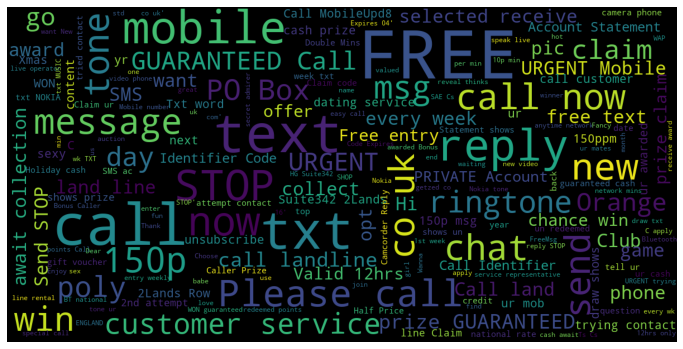

In [27]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

stopwords = set(STOPWORDS)

def get_wordcloud(data, title=None):
    wordcloud=WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40,
        scale=3,
        random_state=1).generate(str(data))
    fig = plt.figure(1, figsize=(12,12))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud)
    plt.show()

get_wordcloud(spam_text)

#### **1.2 Most frequent bi-grams in spam text**

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

word_vect2 = CountVectorizer(ngram_range=(2,2),analyzer='word')
sparse_mat2 = word_vect2.fit_transform(spam_text)
freq2 = sum(sparse_mat2).toarray()[0]

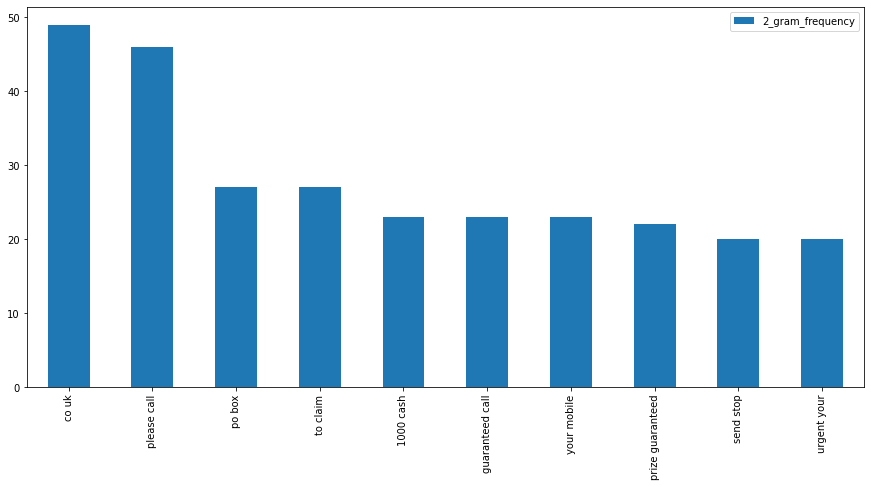

In [29]:
most_2grams = pd.DataFrame(freq2, index=word_vect2.get_feature_names(), columns=['2_gram_frequency']).sort_values(by=['2_gram_frequency'],ascending=False)
most_2grams
most_2grams.head(10).plot.bar(figsize=(15,7))

#### **1.3 Most frequent tri-grams in spam text**

In [0]:
word_vect3 = CountVectorizer(ngram_range=(3,3),analyzer='word')
sparse_mat3 = word_vect3.fit_transform(spam_text)
freq3 = sum(sparse_mat3).toarray()[0]

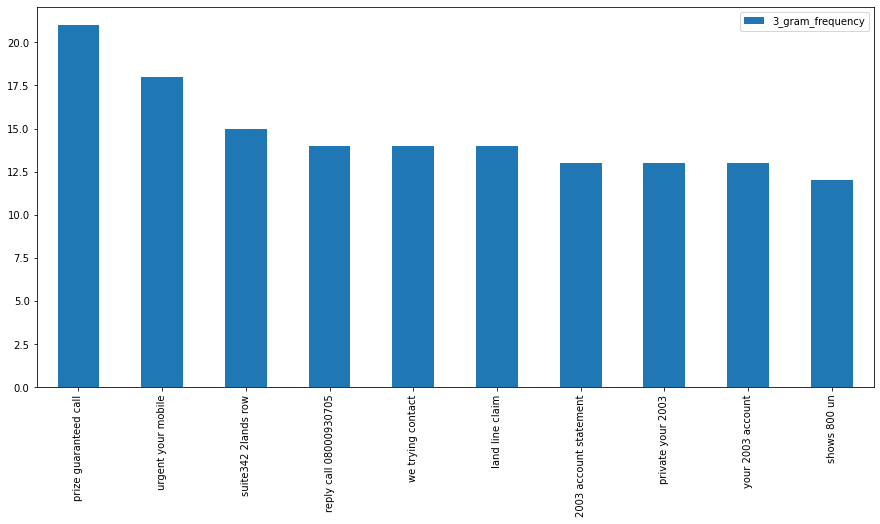

In [31]:
most_3grams = pd.DataFrame(freq3, index=word_vect3.get_feature_names(), columns=['3_gram_frequency']).sort_values(by=['3_gram_frequency'],ascending=False)
most_3grams
most_3grams.head(10).plot.bar(figsize=(15,7))

In [35]:
# checking the data class balance
print("number of non-spam text: " + str(sum(df['Class']==0)))
print("number of spam text: " + str(sum(df['Class']==1)))

number of non-spam text: 4827
number of spam text: 747


In [0]:
texts = df['Text'].tolist()
labels = df['Class'].tolist()

## **2. Binary Classifier - Optimising and Comparing performance of a logistic regression model with a single hidden layer neural network**

In [0]:
# preparing training, validation and testing data

def splitting_data(texts): 
  training_pcnt = 0.7
  validation_pcnt = 0.15

  training_size = int(training_pcnt*len(texts))
  val_test = len(texts) - training_size
  print(training_size)

  validation_border = len(texts) - (int(validation_pcnt * len(texts))) 
  print(validation_border)

  training_texts = texts[0:training_size]
  training_labels = labels[0:training_size]

  validation_texts = texts[training_size:validation_border]
  validation_labels = labels[training_size:validation_border]

  testing_texts = texts[validation_border:]
  testing_labels = labels[validation_border:]

  return training_texts, training_labels, validation_texts, validation_labels, testing_texts, testing_labels

In [0]:
# converting texts to sequences and padding all to a specific length

def tokenizing_and_padding(texts, vector_size, oov_tokn, pad_typ, trunc_typ):
  
  training_texts, training_labels, validation_texts, validation_labels, testing_texts, testing_labels = splitting_data(texts)

  tokenizer = Tokenizer(num_words=vector_size, oov_token=oov_tokn)
  tokenizer.fit_on_texts(training_texts)

  word_index = tokenizer.word_index

  training_sequences = tokenizer.texts_to_sequences(training_texts)
  training_padded = pad_sequences(training_sequences, maxlen=max_length,
                                padding=pad_typ, truncating=trunc_typ)

  validation_sequences = tokenizer.texts_to_sequences(validation_texts)
  validation_padded = pad_sequences(validation_sequences, maxlen=max_length,
                                    padding=padding_type, truncating=trunc_type)

  testing_sequences = tokenizer.texts_to_sequences(testing_texts)
  testing_padded = pad_sequences(testing_sequences, maxlen=max_length,
                                padding=padding_type, truncating=trunc_type)
  return training_padded, training_labels, validation_padded, validation_labels, testing_padded, testing_labels


In [0]:
from keras import backend as K

# functions to calculate f1-score, precision and recall

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
# 1 hidden layer neural network
def train_neural_network(texts, oov_tokn, input_len, trunc_typ, pad_typ, neurons, vocab_size, embedding_dim):

  training_padded, training_labels, validation_padded, validation_labels, testing_padded, testing_labels = tokenizing_and_padding(texts, vocab_size, oov_tokn, pad_typ, trunc_typ)

  model = tf.keras.Sequential([
      tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(neurons, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  # 24
  model.compile(optimizer='adam',loss='binary_crossentropy',
              metrics=['accuracy',f1_m,precision_m, recall_m])

  # fitting the model
  num_epochs = 30
  history = model.fit(training_padded, training_labels, epochs=num_epochs,
                    validation_data=(validation_padded, validation_labels), verbose=2)
  return model, validation_padded, validation_labels, testing_padded, testing_labels, training_padded, training_labels

In [0]:
from sklearn.linear_model import LogisticRegression
def train_logistic_regression(texts, oov_tokn, pad_typ, trunc_typ, vocab_size):
  training_padded, training_labels, validation_padded, validation_labels, testing_padded, testing_labels = tokenizing_and_padding(texts, vocab_size, oov_tokn, pad_typ, trunc_typ)

  logisticRegr = LogisticRegression(solver = 'lbfgs', max_iter=1000)
  logisticRegr.fit(training_padded, training_labels)

  return logisticRegr, testing_padded, testing_labels, training_padded, training_labels

In [0]:
from sklearn.metrics import f1_score

# parameters (arbitrarily chosen)
vocab_size = [100, 1000, 5000, 10000, 50000, 100000]
embedding_dim = [8, 16, 32, 64]
neurons = [5, 25, 50, 100, 200, 400]
max_length = 32
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>" # out of value token 

def optimise_models(texts, oov_tokn, input_len, trunc_typ, pad_typ, neurons, vocab_size, embedding_dim):
  nn_model, validation_padded_nn, validation_labels_nn, testing_padded_nn, testing_labels_nn, training_padded_nn, training_labels_nn = train_neural_network(texts, oov_tokn, input_len, trunc_typ, pad_typ, neurons, vocab_size, embedding_dim)
  logit_model, testing_padded_lr, testing_labels_lr, training_padded_lr, training_labels_lr = train_logistic_regression(texts, oov_tokn, pad_typ, trunc_typ, vocab_size)

  loss, accuracy, f1_score_nn_train, precision, recall = nn_model.evaluate(training_padded_nn, training_labels_nn, verbose=2)
  loss, accuracy, f1_score_nn_test, precision, recall = nn_model.evaluate(testing_padded_nn, testing_labels_nn, verbose=2)



  training_predictions_lr = logit_model.predict(training_padded_lr)
  testing_predictions_lr = logit_model.predict(testing_padded_lr)
  #score = logisticRegr.score(testing_padded_lr, testing_labels_lr)
  f1_score_logit_train = f1_score(training_labels_lr, training_predictions_lr)
  f1_score_logit_test = f1_score(testing_labels_lr, testing_predictions_lr, average='macro')

  return f1_score_nn_train, f1_score_nn_test, f1_score_logit_train, f1_score_logit_test

In [0]:
performance_lr = []
performance_nn = []

for vec_size in vocab_size:
  for emb_dim in embedding_dim:
    for n in neurons:
      print("vec_size: " + str(vec_size) + ", emb_dim: " + str(emb_dim) + ", neurons: " + str (n))
      check_if_i_changed = 0
      f1_score_nn_train, f1_score_nn_test, f1_score_logit_train, f1_score_logit_test = optimise_models(texts, oov_tok, max_length, trunc_type, padding_type, n, vec_size, emb_dim)

      performance_nn.append("vocab_size = " + str(vec_size) + ", embedding_dim =" + str(emb_dim) + ", neurons = " + str(n) + "\n training f1_score =" + str(f1_score_nn_train) + "\n testing f1_score =" + str(f1_score_nn_test))

      if check_if_i_changed != vec_size:
        performance_lr.append("vocab_size =" + str(vec_size) + "\n training f1_score =" + str(f1_score_logit_train) + "\n testing f1_score =" + str(f1_score_logit_test))
        check_if_i_changed = vec_size       


from sklearn.metrics import f1_score

Below the f1-score performance of each model trained with the different combinations of hyperparamters are shown. Here the best hyperparameter tuning can be chosen. A better way to do this is to store the best performing hyperparameters and build a final model automatically but this is just to show how different tunings can give varied performances. Also, graph plots could be used to visualise the different hyperparameter tunings versus the performance. This notebook was completed just as an extracurricular challenge so still, a few things could done be better.

In [0]:
print("*******|||||||                                  |||||||*******")
print("*******|||||||                                  |||||||*******")
print("*******|||||||        Logistic Regression       |||||||*******")
print("*******|||||||                                  |||||||*******")
print("*******|||||||                                  |||||||*******")
print("*******|||||||                                  |||||||*******")
check=""
for perf_lr in performance_lr:
  if perf_lr != check:
    print("--------------------------------------------------")
    print(perf_lr)
    print("--------------------------------------------------")
    check=perf_lr

print("*******|||||||                                  |||||||*******")
print("*******|||||||                                  |||||||*******")
print("*******|||||||  1 Hidden Layer Neural Network   |||||||*******")
print("*******|||||||                                  |||||||*******")
print("*******|||||||                                  |||||||*******")
print("*******|||||||                                  |||||||*******")

for perf_nn in performance_nn:
  print("--------------------------------------------------")
  print(perf_nn)
  print("--------------------------------------------------")

*******|||||||                                  |||||||*******
*******|||||||                                  |||||||*******
*******|||||||        Logistic Regression       |||||||*******
*******|||||||                                  |||||||*******
*******|||||||                                  |||||||*******
*******|||||||                                  |||||||*******
--------------------------------------------------
vocab_size =100
 training f1_score =0.19726858877086495
 testing f1_score =0.5391506964807686
--------------------------------------------------
--------------------------------------------------
vocab_size =1000
 training f1_score =0.43
 testing f1_score =0.6338151554971528
--------------------------------------------------
--------------------------------------------------
vocab_size =5000
 training f1_score =0.40625
 testing f1_score =0.6158088235294118
--------------------------------------------------
--------------------------------------------------
vocab_si